#Setup and preprocessing

In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [ ]:
!ls 

dani_binary_model.ipynb  relevant_or_not.zip  shit.zip	  tlft13_model.h5
dani_model.ipynb	 salva_model.ipynb    submit.zip  tl_model_gap.h5


In [ ]:
!cp relevant_or_not.zip /content

In [ ]:
%cd /content

/content


In [ ]:
# unzip at every run to have ready all images (content is cleaned at any new session)
!unzip relevant_or_not.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: relevant_or_not/train/relevant/11498.jpg  
  inflating: relevant_or_not/train/relevant/11499.jpg  
  inflating: relevant_or_not/train/relevant/11500.jpg  
  inflating: relevant_or_not/train/relevant/11501.jpg  
  inflating: relevant_or_not/train/relevant/11502.jpg  
  inflating: relevant_or_not/train/relevant/11506.jpg  
  inflating: relevant_or_not/train/relevant/11507.jpg  
  inflating: relevant_or_not/train/relevant/11508.jpg  
  inflating: relevant_or_not/train/relevant/11509.jpg  
  inflating: relevant_or_not/train/relevant/11510.jpg  
  inflating: relevant_or_not/train/relevant/11515.jpg  
  inflating: relevant_or_not/train/relevant/11516.jpg  
  inflating: relevant_or_not/train/relevant/11517.jpg  
  inflating: relevant_or_not/train/relevant/11518.jpg  
  inflating: relevant_or_not/train/relevant/11519.jpg  
  inflating: relevant_or_not/train/relevant/11520.jpg  
  inflating: relevant_or_not/train/relevant/11522.jpg 

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
# from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = '/content/relevant_or_not'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
print(training_dir)
labels = ['not_relevant', 'relevant']

/content/relevant_or_not/train


Text(0.5, 1.0, 'Number of training images per category:')

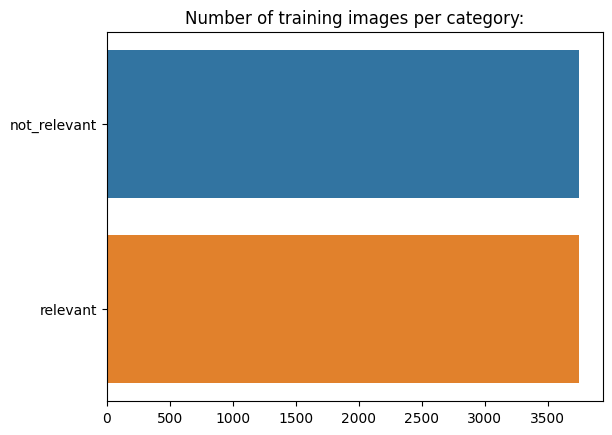

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
# Note that commets line are for here for old augmentations maybe not neccessary in future

aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        #height_shift_range=5,
                                        #width_shift_range=5,
                                        #zoom_range=0.5,
                                        #horizontal_flip=True,
                                        #vertical_flip=True, 
                                        #fill_mode='constant',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 7500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 2)

Categorical label: [1. 0.]
Label: 0
Class name: not_relevant


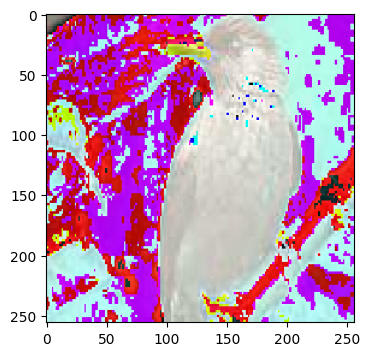

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

#Train

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
      
  callbacks = []

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
input_shape = (256, 256, 3)
epochs = 20

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Flattening (Flatten)        (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                             

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'vgg16_first')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks
).history

Epoch 1/20
235/235 [==============================] - 190s 794ms/step - loss: 0.2695 - accuracy: 0.9476 - precision_2: 0.9476 - recall_2: 0.9476 - val_loss: 0.0629 - val_accuracy: 0.9807 - val_precision_2: 0.9807 - val_recall_2: 0.9807
Epoch 2/20
235/235 [==============================] - 173s 736ms/step - loss: 0.0947 - accuracy: 0.9724 - precision_2: 0.9724 - recall_2: 0.9724 - val_loss: 0.0476 - val_accuracy: 0.9840 - val_precision_2: 0.9840 - val_recall_2: 0.9840
Epoch 3/20
235/235 [==============================] - 186s 790ms/step - loss: 0.0573 - accuracy: 0.9823 - precision_2: 0.9823 - recall_2: 0.9823 - val_loss: 0.0371 - val_accuracy: 0.9873 - val_precision_2: 0.9873 - val_recall_2: 0.9873
Epoch 4/20
235/235 [==============================] - 175s 742ms/step - loss: 0.0384 - accuracy: 0.9875 - precision_2: 0.9875 - recall_2: 0.9875 - val_loss: 0.0484 - val_accuracy: 0.9840 - val_precision_2: 0.9840 - val_recall_2: 0.9840
Epoch 5/20
235/235 [==============================] - 17

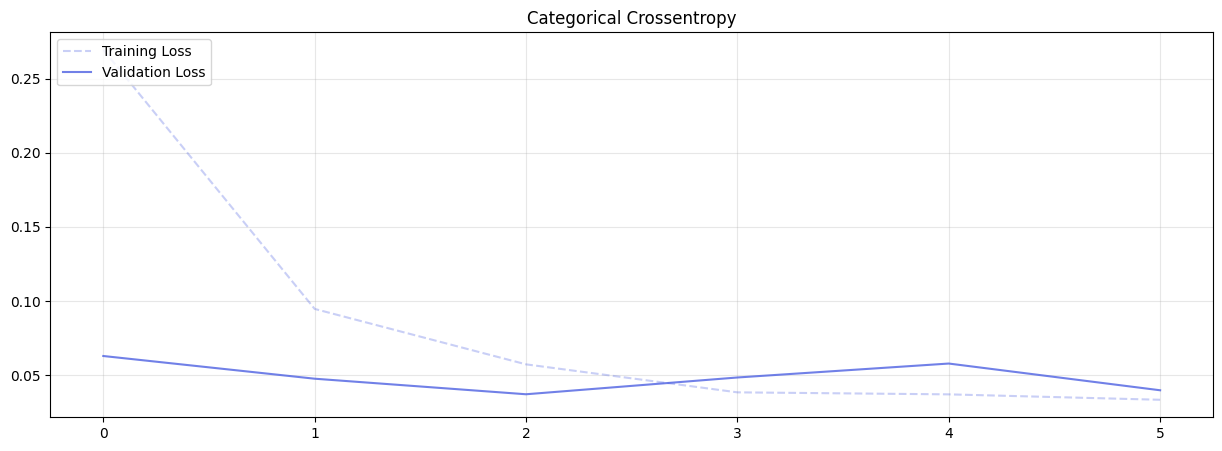

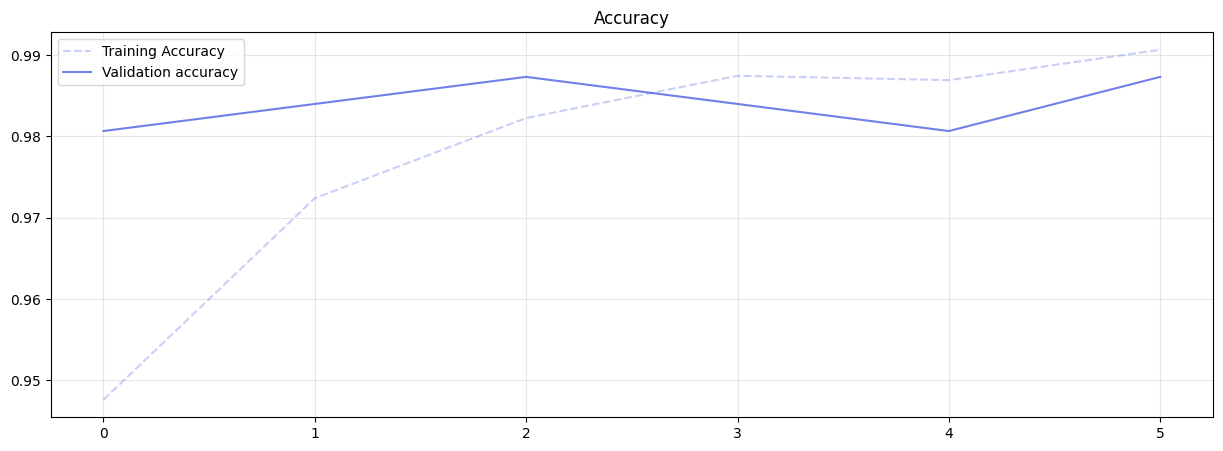

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
import shutil
# Define the folder path where you want to save the model file
folder_path = '/gdrive/MyDrive/bis_project/'

# Define the name of the model file
model_name = 'tl_binary.h5'

# Save the model to a file
tl_model.save(model_name)

# Move the model file to your Google Drive folder
shutil.copy(model_name, folder_path)

print(f'Successfully saved {model_name} to {folder_path}')


Successfully saved tl_binary.h5 to /gdrive/MyDrive/bis_project/


#Load the model

In [ ]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [ ]:
from tensorflow.keras.models import load_model
tl_model=load_model('tl_binary.h5')
tl_model.summary()

In [ ]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:13]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 

In [ ]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 20,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=2 , restore_best_weights=True)],
).history

Epoch 1/20
257/602 [===========>..................] - ETA: 5:12 - loss: 0.4264 - accuracy: 0.8587 - precision_2: 0.8810 - recall_2: 0.8345

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


602/602 [==============================] - 661s 1s/step - loss: 0.3519 - accuracy: 0.8855 - precision_2: 0.9043 - recall_2: 0.8666 - val_loss: 0.2595 - val_accuracy: 0.9274 - val_precision_2: 0.9360 - val_recall_2: 0.9129
Epoch 2/20
602/602 [==============================] - 653s 1s/step - loss: 0.2064 - accuracy: 0.9317 - precision_2: 0.9419 - recall_2: 0.9222 - val_loss: 0.2331 - val_accuracy: 0.9243 - val_precision_2: 0.9362 - val_recall_2: 0.9116
Epoch 3/20
602/602 [==============================] - 659s 1s/step - loss: 0.1691 - accuracy: 0.9469 - precision_2: 0.9537 - recall_2: 0.9411 - val_loss: 0.2395 - val_accuracy: 0.9277 - val_precision_2: 0.9370 - val_recall_2: 0.9173
Epoch 4/20
602/602 [==============================] - 655s 1s/step - loss: 0.1411 - accuracy: 0.9526 - precision_2: 0.9575 - recall_2: 0.9487 - val_loss: 0.2432 - val_accuracy: 0.9339 - val_precision_2: 0.9399 - val_recall_2: 0.9313
Epoch 5/20
602/602 [==============================] - 658s 1s/step - loss: 0.11

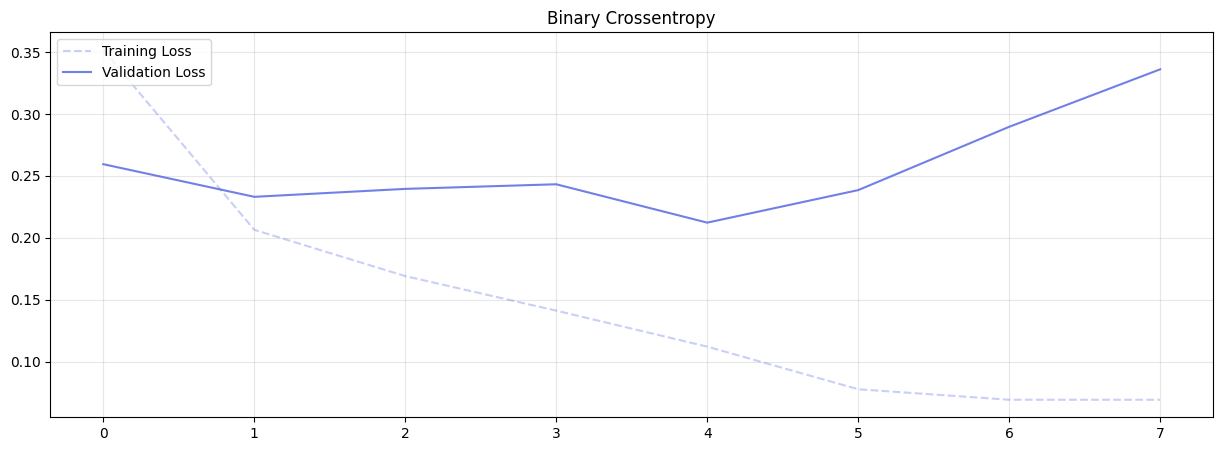

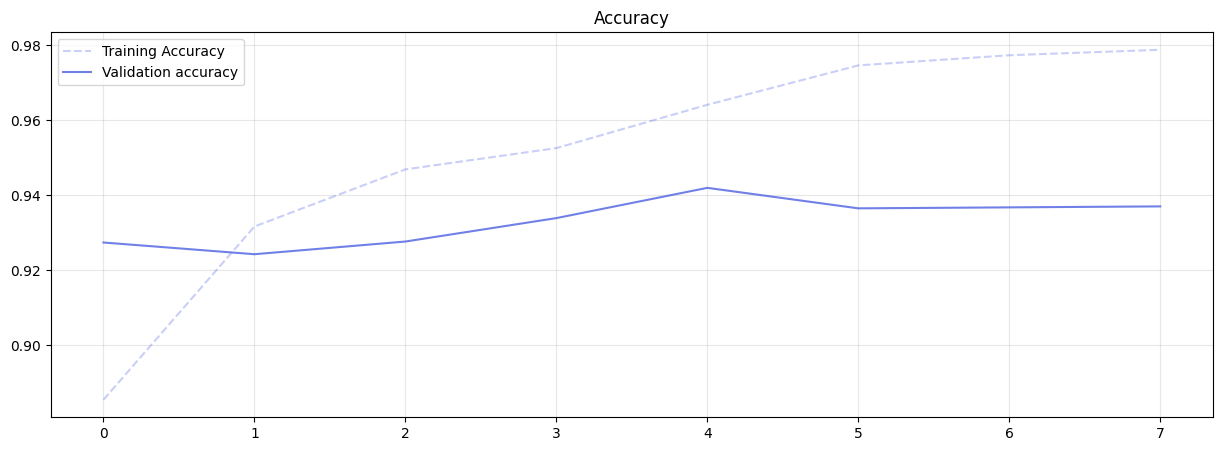

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
import shutil
# Define the folder path where you want to save the model file
folder_path = '/gdrive/MyDrive/'

# Define the name of the model file
model_name = 'tlft13_model.h5'

# Save the model to a file
tl_model.save(model_name)

# Move the model file to your Google Drive folder
shutil.copy(model_name, folder_path)

print(f'Successfully saved {model_name} to {folder_path}')

Successfully saved tlft13_model.h5 to /gdrive/MyDrive/


#Test on the test set from the generator

In [ ]:
# Test the model
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

32/32 [==============================] - 24s 752ms/step - loss: 0.0416 - accuracy: 0.9890 - precision_2: 0.9890 - recall_2: 0.9890

Test metrics
{'loss': 0.04155225679278374, 'accuracy': 0.9890000224113464, 'precision_2': 0.9890000224113464, 'recall_2': 0.9890000224113464}


<ipython-input-36-3dec7973a8ca>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = tl_model.predict_generator(test_gen, steps=224)


Accuracy: 0.989
Precision: 0.989
Recall: 0.989
F1: 0.989


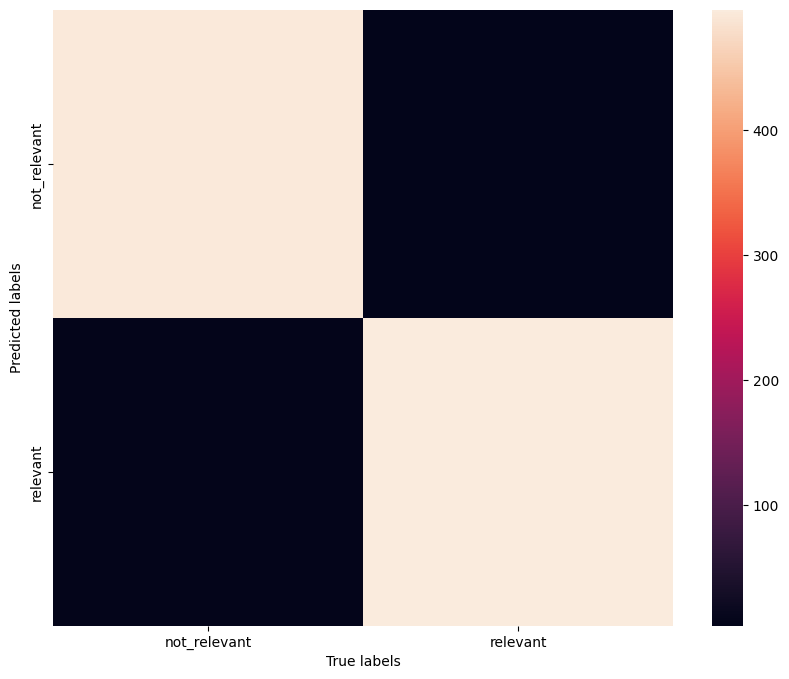

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from PIL import Image

# Assuming your model object is called 'model' and test_gen object is called 'test_gen'
class_labels = ['not_relevant', 'relevant',]  # list of class labels

# Get the next batch of images and labels from test_gen
batch = next(test_gen)

# Select the first image in the batch
img = batch[0][0]

# Convert the image from PIL Image to NumPy array
img_arr = img_to_array(img)

# Preprocess the image
img_arr = preprocess_input(img_arr)

# Convert the NumPy array back to a PIL Image object
img = Image.fromarray(np.clip(img_arr + 127.5, 0, 255).astype(np.uint8))

# Predict class probabilities for the image
probs = tl_model.predict(np.expand_dims(img_arr, axis=0))

# Plot the image and accuracy scores for each class
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(img)
ax1.axis('off')
ax2.bar(np.arange(len(class_labels)), probs[0])
ax2.set_xticks(np.arange(len(class_labels)))
ax2.set_xticklabels(class_labels)
ax2.set_title('Accuracy Scores for Image')
ax2.set_xlabel('Class')
ax2.set_ylabel('Accuracy Score')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
tl_model=load_model('tl_binary.h5')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Flattening (Flatten)        (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                             

In [ ]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [6]:
import urllib.request

# URL of the image to be downloaded
url="https://designobject.it/wp-content/uploads/2022/03/orologio-da-parete-design-classico-elegante-lancette-grandi-binache-metallo-grigio-scuro-nero-minimalista-prezioso-arredamento-chic-sofisticatro-scaled.jpg"
# Local file path to save the downloaded image
file_path = '/content/img7.jpg'

# Download the image from the URL and save it to the local file system
urllib.request.urlretrieve(url, file_path)

('/content/img7.jpg', <http.client.HTTPMessage at 0x7ff08c1ceaa0>)

1/1 [==============================] - 8s 8s/step
[[9.996853e-01 3.147613e-04]]
0


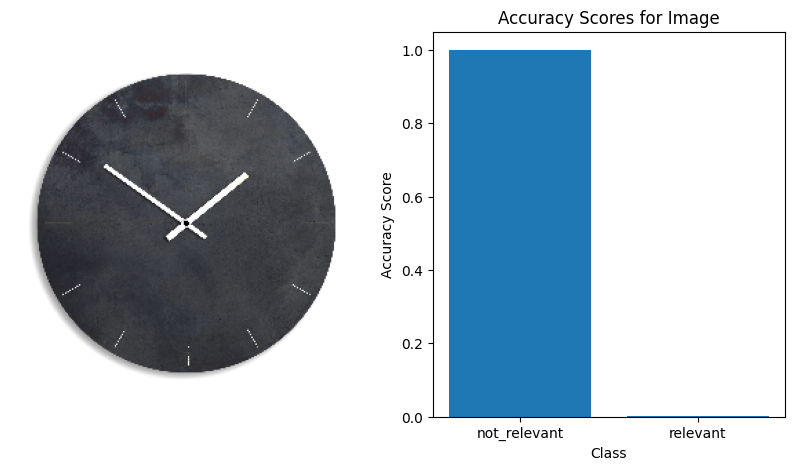

In [7]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load your model
model = load_model('tl_binary.h5')
class_labels = ['not_relevant', 'relevant',]  # list of class labels

# Load and preprocess your image
img_path = file_path
img = load_img(img_path, target_size=(256, 256))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(img_array)

# Use predict() method to get the predictions for the image
predictions = model.predict(preprocessed_img)

print(predictions)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Print the predicted class label
print(predicted_class)


# Plot the image and accuracy scores for each class
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(img)
ax1.axis('off')
ax2.bar(np.arange(len(class_labels)), predictions[0])
ax2.set_xticks(np.arange(len(class_labels)))
ax2.set_xticklabels(class_labels)
ax2.set_title('Accuracy Scores for Image')
ax2.set_xlabel('Class')
ax2.set_ylabel('Accuracy Score')
plt.show()